### Prospeção de Dados 2023/2024 - Course Project
#### Professor: André Falcão
#### Students: 

Catherine Prokhorov (62608) - 6 Hours <br>
Guilherme Cepeda (62931) - 8 Hours <br>
Jorge Aleluia (54549) - 5 Hours <br>
Rómulo Nogueira (56935) - 9 Hours <br>

## Hybrid Approach of Collaborative Filtering algorithm

**Objective**: Implement a hybrid method of Collaborative Filtering (using user-based and item-based)

1. Pre process the data
    - Load the data
    - Select some lines to test our estimator
    - Create a miniHashLsh where we can retrieve the K nearest neighbors of a molecule (based on Jaccard similarity).
    - Create a activity matrix (prot x activity)
    - Center the data (to be used in the user-based algorithm)

2. Implement the user based algorithm
    - Given a ```uniprot_id``` this algorithm should return the top 5 most similar proteins assuming a minimum of 0.5 similarity.

3. Implement the item based algorithm
    - Given a ```molecule_id```.
    - Retrieve the K nearest neighbors of the molecule (Molecules most similar to the given molecule, that have an activity value for the proteins identified in the user-based algorithm)
    - Estimate the activity level as weighted average.

4. Test the estimator with the selected lines (notice that the line of the protein does not count as a neighbor, only as groundTruth).

5. Make the predictions for the ```activity_test_blanked.csv``` file.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# library 
import random
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from helpers import *
from datasketch import MinHash, MinHashLSH
from nltk.metrics import jaccard_distance
from sklearn.metrics import mean_squared_error

## 1. Pre process the data

In [3]:
## Load the data
with open("mol_bits.pkl", "rb") as f:
    MOL_BITS = pickle.load(f)

ACTIVITY_TRAIN = pd.read_csv('activity_train.csv', names=['uniprot_id', 'mol_id', 'activity'])
ACTIVITY_TRAIN["mol_id"] = ACTIVITY_TRAIN["mol_id"].apply(remove_blank_space)

ACTIVITY_TEST = pd.read_csv('activity_test_blanked.csv', names=['uniprot_id', 'mol_id', 'activity'])
ACTIVITY_TEST["mol_id"] = ACTIVITY_TEST["mol_id"].apply(remove_blank_space)

print("Total molecules: ", len(MOL_BITS))
print("Total rows in the train dataset: ", len(ACTIVITY_TRAIN))
print("Total rows in the test dataset: ", len(ACTIVITY_TEST))

Total molecules:  73865
Total rows in the train dataset:  135711
Total rows in the test dataset:  4628


In [4]:
ACTIVITY_TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135711 entries, 0 to 135710
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   uniprot_id  135711 non-null  object
 1   mol_id      135711 non-null  object
 2   activity    135711 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.1+ MB


In [5]:
ACTIVITY_TRAIN

,uniprot_id,mol_id,activity
0,O14842,CHEMBL2022243,4
1,O14842,CHEMBL2022244,6
2,O14842,CHEMBL2022245,2
3,O14842,CHEMBL2022246,1
4,O14842,CHEMBL2022247,4
...,...,...,...
135706,Q9Y5Y4,CHEMBL4214909,6
135707,Q9Y5Y4,CHEMBL4218012,2
135708,Q9Y5Y4,CHEMBL4217503,7
135709,Q9Y5Y4,CHEMBL4204359,8


In [6]:
ACTIVITY_TEST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4628 entries, 0 to 4627
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uniprot_id  4628 non-null   object
 1   mol_id      4628 non-null   object
 2   activity    4628 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 108.6+ KB


In [7]:
ACTIVITY_TEST

,uniprot_id,mol_id,activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,0
4624,Q9Y5Y4,CHEMBL4205421,0
4625,Q9Y5Y4,CHEMBL4207935,0
4626,Q9Y5Y4,CHEMBL4208884,0


##### 1.1 Select some lines to test our estimator (33% of the data)

In [8]:
random.seed(42)
random_indexes = random.sample(range(0, len(ACTIVITY_TRAIN)), len(ACTIVITY_TRAIN) // 33)
ACTIVITY_VAL = ACTIVITY_TRAIN.iloc[random_indexes]
ACTIVITY_VAL["predicted"] = [0] * len(ACTIVITY_VAL)
print("Total rows in the validation dataset: ", len(ACTIVITY_VAL))

Total rows in the validation dataset:  4112


C:\Users\caapv\AppData\Local\Temp\ipykernel_12104\3037102340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACTIVITY_VAL["predicted"] = [0] * len(ACTIVITY_VAL)


#### Plot an Histogram of the activity target variable

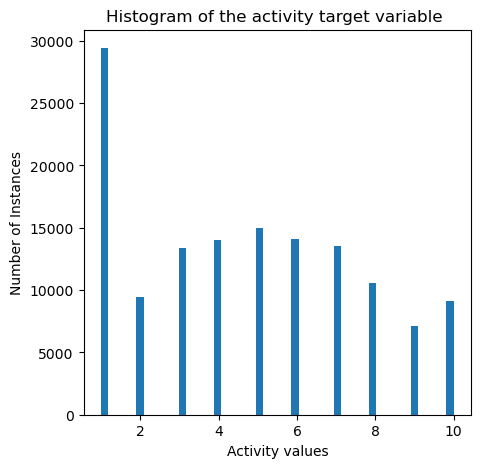

In [9]:
hist, bin_edges = np.histogram(ACTIVITY_TRAIN["activity"], bins=50)
plt.figure(figsize=(5,5))
plt.hist(ACTIVITY_TRAIN["activity"], bins=50)
plt.title('Histogram of the activity target variable ')
plt.ylabel('Number of Instances')
plt.xlabel('Activity values')
plt.show()

In [10]:
# Create MinHashLSH
LSH = MinHashLSH(threshold=0.5, num_perm=256)

# Create MinHash for each molecule
def create_minhash(values):
    m = MinHash(num_perm=256)
    for val in values:
        m.update(str(val).encode('utf8'))
    return m

# Insert MinHashes into LSH
for key, values in MOL_BITS.items():
    m = create_minhash(values)
    LSH.insert(key, m)

"""Find similar keys for a given target key
"""
def find_similar_keys(target_key, threshold=0.5):
    target_minhash = create_minhash(MOL_BITS[target_key])
    result = LSH.query(target_minhash)
    toReturn = {}
    for key in result:
        if key == target_key:
            continue
        score = 1 - jaccard_distance(set(MOL_BITS[target_key]), set(MOL_BITS[key]))
        if score > threshold:
            toReturn[key] = score

    return toReturn

##### 1.2 Create the activity matrix (prot x activity)

In [11]:
# Support functions

def RowCenterMatrix(M):
    V  = M.T
    mat= np.nanmean(V, axis=0)
    VC = V - mat
    VC[np.isnan(VC)]=0
    return VC.T

def create_activityMatrix(rowLabel, colLabel, df):
    rows = list(set(ACTIVITY_TRAIN[rowLabel]))
    cols = list(set(ACTIVITY_TRAIN[colLabel]))
    n_rows = len(rows)
    n_cols = len(cols)

    rows = dict(zip(rows, np.arange(n_rows)))
    cols = dict(zip(cols, np.arange(n_cols)))
    mat = np.zeros((n_rows, n_cols))
    # mat[mat==0]=np.nan
    for rw in df.values:
        mat[rows[rw[0]], cols[rw[1]]]=rw[2]
    return mat, rows, cols

In [12]:
MAT, MAP_PROTS, MAP_MOLS=create_activityMatrix("uniprot_id", "mol_id", ACTIVITY_TRAIN)
MAT_CENTERED = RowCenterMatrix(MAT)

In [13]:
# Support function

def CosSim_SingleRow(M, row_index):
    # Extract he specific row
    target_row = M[row_index, :]
    
    # Calculate the norms of all rows
    norms = np.sqrt(np.sum(M * M, axis=1))
    norms[norms < 0.001] = 0.001  # This solves the lines or columns without variance

    # Calculate the norm of the target row
    target_norm = norms[row_index]
    
    # Calculate the dot product of the target row with all other rows
    dot_products = np.dot(M, target_row)
    
    # Calculate the similarity of the target row with all other rows
    cos_similarities = dot_products / (norms * target_norm)
    
    return cos_similarities

## 2. Implement the user based algorithm

This algorithm uses the ```unitprot_id``` and check in with ```Pearson Correlation Coefficient``` the similarity between the proteins, returning the top 5 most similar proteins.

In [14]:
def get_similar_prots(target_prot, threshold=0.5):
    target_prot_index = MAP_PROTS[target_prot]
    df = pd.DataFrame(CosSim_SingleRow(MAT_CENTERED, target_prot_index), index=MAP_PROTS.keys(), columns=[target_prot])
    df_filtrado = df[df[target_prot] > threshold].sort_values(by=target_prot, ascending=False).head()
    return df_filtrado.to_dict()[target_prot]

## 3. Implement the item based algorithm

In [15]:
def global_mean(use_case:pd.Series):
    subset = ACTIVITY_TRAIN[ACTIVITY_TRAIN["uniprot_id"] == use_case["uniprot_id"]]
    return round(subset["activity"].mean())

def estimate_score(use_case: pd.Series, knn:dict, similar_prots: dict, INT = True):

    # Retrieve the set of molecules that the protein has activity for
    uniprot_mols = set(ACTIVITY_TRAIN[ACTIVITY_TRAIN["uniprot_id"].isin(similar_prots.keys())]["mol_id"].values)

    # Intercept the set of molecules that the protein has activity for and the set of molecules that are similar to the molecule
    sim_mols = set(knn.keys())
    intercept_mols = sim_mols.intersection(uniprot_mols)

    # Get a subset of the training data that contains only the molecules that are similar to the molecule and the protein
    subset = ACTIVITY_TRAIN[ACTIVITY_TRAIN["mol_id"].isin(intercept_mols) & ACTIVITY_TRAIN["uniprot_id"].isin(similar_prots.keys())]

    # If the subset is empty, return the global mean
    if knn == {} or intercept_mols == {} or subset.empty:
        return global_mean(use_case)
    
    # Calculate the estimated score

    # Create a dict for each similar protein that shares ate least one similar molecule (because they are going to have different weights in the final score)
    count = {d : {"num": 0, "den":0, "weigth": similar_prots[d]} for d in subset["uniprot_id"].unique()} 

    for _, row in subset.iterrows():
        count[row["uniprot_id"]]["num"] += knn[row["mol_id"]] * row["activity"]
        count[row["uniprot_id"]]["den"] += knn[row["mol_id"]]

    final_num = 0
    final_den = 0
    for key in count.keys():
        count[key]["score"] = round(count[key]["num"] / count[key]["den"])
        final_num += count[key]["score"] * count[key]["weigth"]
        final_den += count[key]["weigth"]


    if INT:
        return round(final_num / final_den)
    else:
        return round(final_num / final_den, 3)

## 4. Test on the validation set

In [16]:
THRESHOLD_MOLS = 0.5
THRESHOLD_PROTS = 0.75

In [17]:
# with 33% of train to do the validation
list_preds_val = []
for i in range(len(ACTIVITY_VAL)):
    # Get the use case
    use_case = ACTIVITY_VAL.iloc[i]

    # Find the similar molecules
    knn = find_similar_keys(use_case["mol_id"], threshold=THRESHOLD_MOLS)

    # Find the similar proteins
    similar_prots = get_similar_prots(use_case["uniprot_id"], threshold=THRESHOLD_PROTS)

    # Estimate the score
    pred = estimate_score(use_case, knn, similar_prots, INT=False)
    
    # Append the prediction to the list
    list_preds_val.append(pred)


In [18]:
ACTIVITY_VAL["predicted"] = list_preds_val

C:\Users\caapv\AppData\Local\Temp\ipykernel_12104\3589990721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACTIVITY_VAL["predicted"] = list_preds_val


In [19]:
ACTIVITY_VAL

,uniprot_id,mol_id,activity,predicted
29184,P20309,CHEMBL206127,4,4.000
6556,P08173,CHEMBL75880,3,4.000
72097,P32245,CHEMBL393789,5,8.000
64196,P30542,CHEMBL258755,1,1.000
58513,P29274,CHEMBL4566592,1,2.000
...,...,...,...,...
75096,P34969,CHEMBL2164342,5,8.000
15063,P0DMS8,CHEMBL375501,5,6.000
45946,P28222,CHEMBL1241546,9,9.429
129595,Q9H3N8,CHEMBL1915347,5,6.000


#### Plot a graph for the predictions

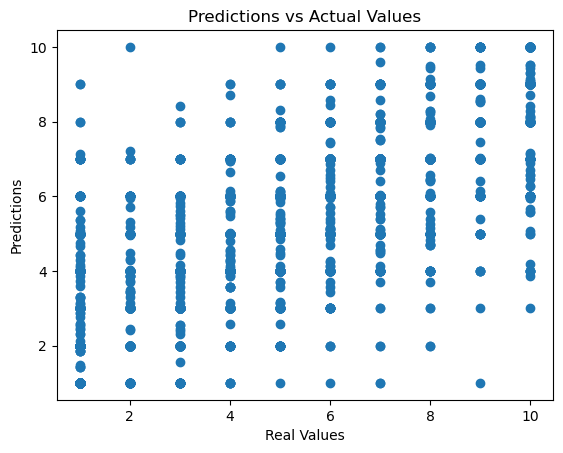

In [20]:
# Visualization of the predictions vs the actual values
plt.scatter(ACTIVITY_VAL["activity"], ACTIVITY_VAL["predicted"])
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Predictions vs Actual Values')
plt.show()


##### Evaluate the model with floats

In [21]:
ACTIVITY_VAL["error"] = diff_percent(ACTIVITY_VAL["activity"], ACTIVITY_VAL["predicted"])

C:\Users\caapv\AppData\Local\Temp\ipykernel_12104\3685725647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACTIVITY_VAL["error"] = diff_percent(ACTIVITY_VAL["activity"], ACTIVITY_VAL["predicted"])


In [22]:
ACTIVITY_VAL

,uniprot_id,mol_id,activity,predicted,error
29184,P20309,CHEMBL206127,4,4.000,0.0
6556,P08173,CHEMBL75880,3,4.000,25.0
72097,P32245,CHEMBL393789,5,8.000,37.5
64196,P30542,CHEMBL258755,1,1.000,0.0
58513,P29274,CHEMBL4566592,1,2.000,50.0
...,...,...,...,...,...
75096,P34969,CHEMBL2164342,5,8.000,37.5
15063,P0DMS8,CHEMBL375501,5,6.000,16.7
45946,P28222,CHEMBL1241546,9,9.429,4.5
129595,Q9H3N8,CHEMBL1915347,5,6.000,16.7


In [23]:
rows_error_less_or_equal_than_25 = ACTIVITY_VAL[ACTIVITY_VAL["error"] <= 25]
rows_error_less_or_equal_than_50_and_more_than_25 = ACTIVITY_VAL[(ACTIVITY_VAL["error"] <= 50) & (ACTIVITY_VAL["error"] > 25)]
rows_error_more_than_50 = ACTIVITY_VAL[ACTIVITY_VAL["error"] > 50] 

print(f"Number of rows with error <= 25%: {len(rows_error_less_or_equal_than_25)}")
print(f"Number of rows with 25% < error <= 50%: {len(rows_error_less_or_equal_than_50_and_more_than_25)}")
print(f"Number of rows with error > 50%: {len(rows_error_more_than_50)}")

print()
print(f"Total number of rows: {len(ACTIVITY_VAL)}")
print()

print("In percentage:")
print(f"Number of rows with error <= 25%: {round(len(rows_error_less_or_equal_than_25) / len(ACTIVITY_VAL) * 100, 1)}%")
print(f"Number of rows with 25% < error <= 50%: {round(len(rows_error_less_or_equal_than_50_and_more_than_25) / len(ACTIVITY_VAL) * 100,1)}%")
print(f"Number of rows with error > 50%: {round(len(rows_error_more_than_50) / len(ACTIVITY_VAL) * 100, 1)}%")

Number of rows with error <= 25%: 2505
Number of rows with 25% < error <= 50%: 970
Number of rows with error > 50%: 637

Total number of rows: 4112

In percentage:
Number of rows with error <= 25%: 60.9%
Number of rows with 25% < error <= 50%: 23.6%
Number of rows with error > 50%: 15.5%


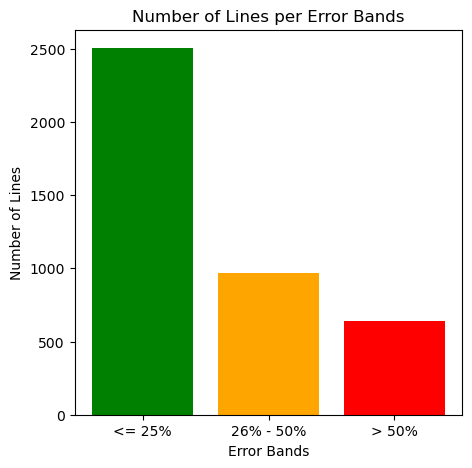

In [24]:
len_less_or_equal_25 = len(rows_error_less_or_equal_than_25)
len_less_or_equal_50_more_than_25 = len(rows_error_less_or_equal_than_50_and_more_than_25)
len_more_than_50 = len(rows_error_more_than_50)

categories = ['<= 25%', '26% - 50%', '> 50%']
counts = [len_less_or_equal_25, len_less_or_equal_50_more_than_25, len_more_than_50]

plt.figure(figsize=(5, 5))
plt.bar(categories, counts, color=['green', 'orange', 'red'])
plt.xlabel('Error Bands')
plt.ylabel('Number of Lines')
plt.title('Number of Lines per Error Bands')
plt.show()

#### MSE

In [25]:
## mean squared error
print("Mean Squared Error: ")
print(round(mean_squared_error(ACTIVITY_VAL["activity"], list_preds_val), 3))

Mean Squared Error: 
2.967


## 5. Evaluation on the Test set 
On the ```activity_test_blanked.csv``` file

In [26]:
list_preds_test = []
for i in range(len(ACTIVITY_TEST)):
    # Get the use case
    use_case = ACTIVITY_TEST.iloc[i]

    # Find the similar molecules
    knn = find_similar_keys(use_case["mol_id"], threshold=THRESHOLD_MOLS)

    # Find the similar proteins
    similar_prots = get_similar_prots(use_case["uniprot_id"], threshold=THRESHOLD_PROTS)

    # Estimate the score
    pred = estimate_score(use_case, knn, similar_prots, INT=False)
    
    # Append the prediction to the list
    list_preds_test.append(pred)


In [27]:
ACTIVITY_TEST["activity"] = list_preds_test

In [28]:
ACTIVITY_TEST

,uniprot_id,mol_id,activity
0,O14842,CHEMBL2022258,6.0
1,O14842,CHEMBL2047161,6.0
2,O14842,CHEMBL2047163,6.0
3,O14842,CHEMBL2047168,6.0
4,O14842,CHEMBL2047169,6.0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,7.0
4624,Q9Y5Y4,CHEMBL4205421,5.0
4625,Q9Y5Y4,CHEMBL4207935,7.0
4626,Q9Y5Y4,CHEMBL4208884,7.0


#### Export the predictions to a .csv file

In [29]:
predictions_df = ACTIVITY_TEST.copy()
# Save predictions in a .csv file 
predictions_df.to_csv("PD_PREDS_01.csv", sep=";", index=False)
predictions_df.to_csv("preds_01.txt", sep=";", index=False)